Weak perturbation
=================

In this first numerical experiment we consider the propagation of a small perturbation in a collisionless plasma model. The perturbation is initiated by a thin slab of fluid slowly moving with respect to the surrounding resting fluid. The slab is translationally invariant in the y direction and moving in the x direction.
We qualify the perturbation as "small" if the initial speed of the slab is small with respect to the sound speed $c=\sqrt{\gamma T}$, where $\gamma$ is the adiabatic index and $T$ the fluid temperature.

In [1]:
root_path  = "/home/katanovic/fluid_kinetic_class/"
phare_path = "/home/katanovic/PHARE"

In [2]:
import os
import sys
phare_root = os.path.expanduser(phare_path)
sys.path.append(os.path.join(phare_path, "pyphare"))
sys.path.append(os.path.join(root_path, "2024"))

from pyphare.pharesee.run import Run
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as gf
from numpy import polyfit
from scipy.signal import find_peaks
from scripts import dist_plot

%matplotlib widget

In [3]:
root_path  = "/home/katanovic/fluid_kinetic_class/2024/run/weak"
phare_path = "/home/katanovic/PHARE/"

# Misc functions to get data

In [4]:
def get_velocities(r,times, sigma=6):
    for it,t in enumerate(times):
        Vi = r.GetVi(t, merged=True)
        Vix = Vi["Vx"][0]
        xV = Vi["Vx"][1][0]
        if sigma >0:
            v = gf(Vix(xV),sigma)
        else:
            v = Vix(xV)
        if it==0 :
            vt = np.zeros((len(v),len(times)))
            vt[:,it] = v
    return xV, vt

def get_densities(r,times, sigma=6):
    for it,t in enumerate(times):
        N = r.GetNi(t, merged=True)
        Ni = N["rho"][0]
        x = N["rho"][1][0]
        if sigma >0:
            n = gf(Ni(x),sigma)
        else:
            n = Ni(x)
        if it==0 :
            nt = np.zeros((len(n),len(times)))
        nt[:,it] = n
    return x, nt

def get_electric(r,times, sigma=6):
    for it,t in enumerate(times):
        E = r.GetE(times, merged=True)
        Ex = E["Ex"][0]
        x = E["Ex"][1][0]
        if sigma >0:
            e = gf(Ex(x),sigma)
        else:
            e = Ex(x)
        if it==0 :
            et = np.zeros((len(e),len(times)))
        et[:,it] = e
    return x, et

def get_peaks(x,Vs):
    nt = Vs.shape[1]
    positions  = np.zeros((nt,2))
    amplitudes = np.zeros((nt,2))
    for it in range(nt):
        ps = find_peaks(Vs[:,it], height=0.010)
        if (len(ps[0])==1):
            positions[it,0] = x[ps[0]]
            positions[it,1] = x[ps[0]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][0],it]
        else:
            positions[it,0]  = x[ps[0][0]]
            positions[it,1]  = x[ps[0][1]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][1],it]
    return positions, amplitudes

def profiles(times, x, Vs, positions, temperature):
    fig, ax = plt.subplots()
    for it,t in enumerate(times):
        ax.plot(x, Vs[:,it], label=r"t={:6.4f}".format(t))
        ax.set_ylim((-0.03, 0.1))
        ax.axhline(0, ls='--', color='k')
        for p in positions[it,:]:
            ax.axvline(p, color="gray", ls="-.")
    ax.set_title("$T_e$ = {:6.4f}".format(temperature))
    ax.legend()

def propagation(times, positions, temperature):
    fig,ax = plt.subplots()
    ax.plot(times,positions[:,0], marker="o", color="r", ls="None")
    vl,originl = polyfit(times, positions[:,0], 1)
    ax.plot(times, times*vl+originl, color="r")
    ax.plot(times,positions[:,1], marker="o", color="b", ls="None")
    vr,originr = polyfit(times, positions[:,1], 1)
    ax.plot(times, times*vr+originr, color="b")
    ax.set_title("T = {:6.4f}, Vl = {:6.4f}, Vr = {:6.4f}".format(temperature, vl, vr))

def damping(times, amplitudes, **kw):
    fig,ax = plt.subplots()
    ax.plot(times,amplitudes[:,0], marker="o", color="r", ls="None")
    ax.plot(times,amplitudes[:,1], marker="o", color="b", ls="None")
    ax.set_ylim((0,0.1))



def phase_space(time, r, **kwargs):

    ions = r.GetParticles(time, ["protons",])
    vmin = kwargs.get("vmin", -2)
    vmax = kwargs.get("vmax", 2)    
    dv   = kwargs.get("dv", 0.05)
    nvbins = int((vmax-vmin)/dv)
    vbins = vmin + dv*np.arange(nvbins)
    nxbins = kwargs.get("nxbins", 512)
    dx     = kwargs.get("dx", 0.25)
    xbins = dx*np.arange(nxbins)+dx/2

    fig, ax = plt.subplots(figsize=(10, 4))
    p,f=ions.dist_plot(axis=("x", "Vx"),
                       ax=ax,
                       norm=0.4,                 
                       # levels=(0,),  # default is (0,), tuple of all levels to overplot
                       # bulk=True,  # draw line(s) at mean vel. on vel. axis
                       # xlim=(0,20),  # default takes full data range
                       # ylim=(-2,2),  # default takes full data range
                       # sigma = (1,1),  # gaussian filter 2D
                       # filename=myImage.png,  # will save result in file
                       gaussian_filter_sigma=0,
                       bins=(xbins,vbins),
                       title="Strong perturbation at time : {:.2f}".format(time), # figure title
                       # xlabel="my x label", # default is name of chosen axis[0]
                       # ylabel= "my y label", # default is name of chosen axis[1]
                       # kde = True,     # default False, draws kernel density estimate contours
                       interp=True,
                      )

    return fig, ax, p, f

# WP1

## Goal

You will execute 4 runs. The runs only differ by the electron temperature. 

- $T_e = 0.0$
- $T_e = 0.05$
- $T_e = 0.25$
- $T_e = 0.5$
- $T_e = 2.5$

## Run PHARE

- Open a terminal (File>New>Terminal)
- execute `pwd`, you should see `/home/user/PHARE` indicating you're in the PHARE directory
- execute `git clone https://github.com/PHAREHUB/fluid_kinetic_class`
- execute `cd fluid_kinetic_class/2024/run/weak/`


In there you will see a script called `wp1.py` that will configure a PHARE simulation for you.\
To run it for a temperature $Te= 0.1$ do:

```bash
python3 wp1.py 0.1
```

This should run and produce outputs in the directory:

- `wp_0.1/`


To run the analysis for a specific run you did, execute cells below after changing the value of the variable  `Te` to the one associated with the run you want to see.



In [11]:
Te = 0.0
Ti = 0.01

In [12]:
path = root_path+"/"+f"wp_{Te}"
times = np.asarray((0, 20, 40, 60, 80, 100))
r = Run(path)

# test

Text(0, 0.5, 'B component')

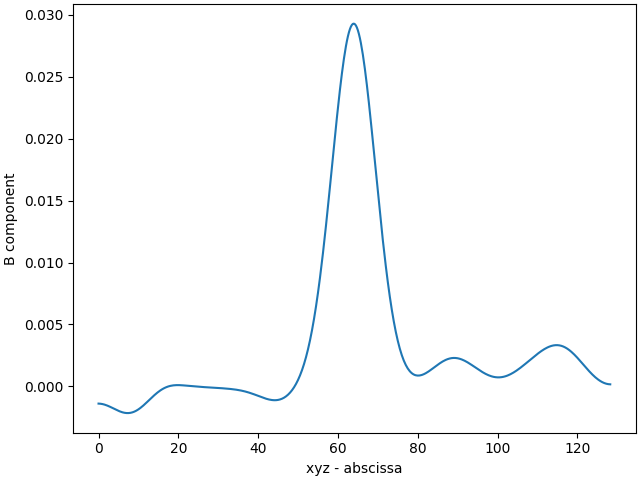

In [13]:
test = r.GetVi(0.0, merged = True)
E = r.GetE(0, merged=True)

Vx, x = test["Vx"]
x = x[0]

vx = Vx(x)

v = gf(vx, 20)

fig, ax = plt.subplots(1,1, constrained_layout=True)

ax.plot(x,v)

ax.set_xlabel("xyz - abscissa")
ax.set_ylabel("B component")

In [17]:
x, Vs = get_velocities(r,times, sigma=6)
print(x, Vs)

[  0.     0.25   0.5    0.75   1.     1.25   1.5    1.75   2.     2.25
   2.5    2.75   3.     3.25   3.5    3.75   4.     4.25   4.5    4.75
   5.     5.25   5.5    5.75   6.     6.25   6.5    6.75   7.     7.25
   7.5    7.75   8.     8.25   8.5    8.75   9.     9.25   9.5    9.75
  10.    10.25  10.5   10.75  11.    11.25  11.5   11.75  12.    12.25
  12.5   12.75  13.    13.25  13.5   13.75  14.    14.25  14.5   14.75
  15.    15.25  15.5   15.75  16.    16.25  16.5   16.75  17.    17.25
  17.5   17.75  18.    18.25  18.5   18.75  19.    19.25  19.5   19.75
  20.    20.25  20.5   20.75  21.    21.25  21.5   21.75  22.    22.25
  22.5   22.75  23.    23.25  23.5   23.75  24.    24.25  24.5   24.75
  25.    25.25  25.5   25.75  26.    26.25  26.5   26.75  27.    27.25
  27.5   27.75  28.    28.25  28.5   28.75  29.    29.25  29.5   29.75
  30.    30.25  30.5   30.75  31.    31.25  31.5   31.75  32.    32.25
  32.5   32.75  33.    33.25  33.5   33.75  34.    34.25  34.5   34.75
  35. 

In [15]:
def get_peaks(x,Vs):
    nt = Vs.shape[1]
    positions  = np.zeros((nt,2))
    amplitudes = np.zeros((nt,2))
    for it in range(nt):
        ps = find_peaks(Vs[:,it], height=0.010)
        if (len(ps[0])==1):
            positions[it,0] = x[ps[0]]
            positions[it,1] = x[ps[0]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][0],it]
        else:
            positions[it,0]  = x[ps[0][0]]
            positions[it,1]  = x[ps[0][1]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][1],it]
    return positions, amplitudes

In [16]:
positions, amplitudes = get_peaks(x,Vs)
profiles(times, x, Vs, positions, Te)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
propagation(times, positions, Te)

In [ ]:

Gamma_e = 1
Gamma_i = 3
print("ion acoustic speed : ", np.sqrt(Gamma_e*Te+Gamma_i*Ti))

In [ ]:
damping(times, amplitudes)

In [ ]:
fig, ax1, p, f = phase_space(40, r, dv=0.05, vmin=-0.8, vmax=0.8)

In [ ]:
time=40
ions = r.GetParticles(time, "protons")
fig, ax = plt.subplots(figsize=(10,4))
p,f = dist_plot(ions,
                axis=("x", "Vx"),
                ax=ax,            # default creates the figure                
                vmin=-1,vmax=1,
                dv=0.01,                    
                title="weak perturbation at time : {:.2f}".format(time), # figure title
                plot_type="scatter"
                )

# Champ électrique


In [ ]:
E = r.GetE(0, merged=True)
ey_, y_ = E["Ey"]
ez_, z_ = E["Ez"]
y_a = y_[0]
z_a = z_[0]
ey_a = ey_(y_a)
ez_a = ez_(z_a)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

ax.plot(y_a, ey_a, label="$E_y$")
ax.plot(z_a, ez_a, label="$E_z$")

ax.legend()
ax.set_xlabel("yz")
ax.set_ylabel("E component")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)

ax.plot(ey_a, ez_a)

ax.plot(ey_a[0], ez_a[0], marker="o", label="x = 0", color="k")
ax.plot(ey_a[20], ez_a[20], marker="s", label=f"x = {y_a[20]}", color="r")

ax.legend()
ax.set_xlabel("$E_y$")
ax.set_ylabel("$E_z$")
ax.set_aspect("equal")

# Champ magnétique

In [ ]:
B = r.GetB(time, merged=True)

bx_, x_ = B["Bx"]
by_, y_ = B["By"]
bz_, z_ = B["Bz"]

x_a = x_[0]
y_a = y_[0]
z_a = z_[0]

bx_a = bx_(x_a)
by_a = by_(y_a)
bz_a = bz_(z_a)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)

ax.plot(y_a, by_a, label="$B_y$")
ax.plot(z_a, bz_a, label="$B_z$")

ax.legend()
ax.set_xlabel("xyz - abscissa")
ax.set_ylabel("B component")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Tracer l'évolution du champ électrique dans l'espace (E_x par rapport à E_y et E_z)
ax.plot(bx_a[:513], by_a[:513], bz_a[:513], color='b', label="Champ électrique")

# Ajouter des labels aux axes
ax.set_xlabel('$E_x$')
ax.set_ylabel('$E_y$')
ax.set_zlabel('$E_z$')

# Ajouter la légende
ax.legend()

# Afficher le graphique
plt.show()